Import Libraries

In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from contractions import fix
import tensorflow as tf
import sklearn
import string

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, pipeline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


c:\Python312\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Python312\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
df = pd.read_csv('for_export_philippine_elections.csv')
pd.set_option('display.max_colwidth', None)
df

,pseudo_id,text,retweetCount,replyCount,likeCount,quoteCount,viewCount,bookmarkCount,createdAt,lang,isReply,pseudo_conversationId,pseudo_inReplyToUsername,pseudo_author_userName,author_isVerified,author_isBlueVerified
0,3301549258506648906,@477909166155288677 Di bale nang Vangag at Isinuka huwag lang sakupin ang Pilipinas ng China. \r\n\r\nSa Mga Kababayan kong Pilipino: Huwag iboto mga politikong Pro-China kung ayaw niyong maging alipin tayo ng mga intsik sa sarili nating bayan. https://t.co/86wKJz6hg9,0,0,0,0,1,0,2025-02-16 15:56:47+00:00,tl,True,9195137463543224666,477909166155288677,4453171638842282341,False,False
1,3225753269123892664,kapag bobo pa rin bumoto sumagi sana sa isip niyo na 'wag na mandamay ng gusto ng good governance pls. 😩🙏,0,0,2,0,2,0,2025-02-16 15:51:44+00:00,tl,False,3225753269123892664,9379265972706784,1775748541153565653,False,False
2,5673627845733139909,"With limited resources compared to other candidates, Leody de Guzman will prioritize maximizing social media for his 2025 senatorial campaign. #Halalan2025 \r\n\r\nREAD: https://t.co/EPundqubIx https://t.co/fQRd7EJeGd",0,0,1,0,664,0,2025-02-16 15:50:16+00:00,en,False,5673627845733139909,9379265972706784,3719547946581141638,False,True
3,4354735009826378974,@4065824813125858448 ANY SUPPORT WE CAN GET NA TALAGA. WALA TAYONG CHOICE. HINDI NAMAN NATIN KAILANGAN IBOTO SI GRACE POE,0,0,1,0,18,0,2025-02-16 15:49:18+00:00,tl,True,4296348514022306266,4065824813125858448,6765254504367043701,False,False
4,34690230098045792,ito yung kailangan natjng gobyerno this Halalan 2025!! hindi takot i-call out yung mga corrupt !!!,0,0,0,0,9,0,2025-02-16 15:46:06+00:00,tl,False,34690230098045792,9379265972706784,60909766723235379,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20922,8144420702448116610,Kunin nyo Pera tapos wag nyong iboto.,0,0,0,0,42,0,2024-12-25 05:59:01+00:00,tl,False,8144420702448116610,9379265972706784,1531330201062943361,False,False
20923,2407594886499303984,"@4503621067685019618 @2624308399346108740 wag mo na daw iboto, mananalo pa rin naman",0,0,0,0,17,0,2024-12-25 05:58:20+00:00,tl,True,2469799784332586467,4503621067685019618,1344529858908806221,False,False
20924,6787169807997372827,@6646584678430457581 Haha nabuking lang ang amo wag na daw iboto.,0,0,1,0,21,0,2024-12-25 05:55:05+00:00,tl,True,9074506979857344293,6646584678430457581,5685480686320180917,False,False
20925,156352743593572173,"Mga kababayang bisaya isipin ninyo lang bakit inireklamo ng mga babae nirape ni fucking quibulok at nagtatago siya noon una, di naman kayo bobo mga kababayang bisaya, malaki ang regard ko sa inyo wag iboto ang mga dutertes at indaysalot Sara dayukdok Duterte at mga asong senador",0,0,0,0,39,0,2024-12-25 05:39:52+00:00,tl,False,156352743593572173,9379265972706784,8667609127399135160,False,False


**DATA PREPROCESSING**

In [3]:
# dropping unneeded columns

df = df.drop(columns=['pseudo_conversationId','pseudo_inReplyToUsername', 'pseudo_author_userName', 'bookmarkCount', 'pseudo_conversationId', 'pseudo_inReplyToUsername', 'pseudo_author_userName', 'author_isVerified', 'author_isBlueVerified']) # drop unneeded columns

In [4]:
df.drop_duplicates(subset=['text'], inplace=True) # drop duplicates

In [5]:
df.isnull().sum() # check null

pseudo_id       0
text            0
retweetCount    0
replyCount      0
likeCount       0
quoteCount      0
viewCount       0
createdAt       0
lang            0
isReply         0
dtype: int64

Normalizing Text

In [6]:
def clean_text(text):
    # lowercase
    text = text.lower()
    # fix contractions
    text = fix(text)
    # remove urls
    text = re.sub(r"http\S+|www\S+", "", text)
    # remove mentions and hashtags
    text = re.sub(r"@\w+|#\w+", "", text)
    # remove special characters and numbers
    text = re.sub(r"[^a-z0-9\s]", "", text)
    # remove extra spaces and new lines
    text = re.sub(r"\s+", " ", text).strip()

    return text

df['text'] = df['text'].apply(clean_text)

df

,pseudo_id,text,retweetCount,replyCount,likeCount,quoteCount,viewCount,createdAt,lang,isReply
0,3301549258506648906,di bale nang vangag at isinuka huwag lang sakupin ang pilipinas ng china sa mga kababayan kong pilipino huwag iboto mga politikong prochina kung ayaw niyong maging alipin tayo ng mga intsik sa sarili nating bayan,0,0,0,0,1,2025-02-16 15:56:47+00:00,tl,True
1,3225753269123892664,kapag bobo pa rin bumoto sumagi sana sa isip niyo na wag na mandamay ng gusto ng good governance pls,0,0,2,0,2,2025-02-16 15:51:44+00:00,tl,False
2,5673627845733139909,with limited resources compared to other candidates leody de guzman will prioritize maximizing social media for his 2025 senatorial campaign read,0,0,1,0,664,2025-02-16 15:50:16+00:00,en,False
3,4354735009826378974,any support we can get na talaga wala tayong choice hindi naman natin kailangan iboto si grace poe,0,0,1,0,18,2025-02-16 15:49:18+00:00,tl,True
4,34690230098045792,ito yung kailangan natjng gobyerno this halalan 2025 hindi takot icall out yung mga corrupt,0,0,0,0,9,2025-02-16 15:46:06+00:00,tl,False
...,...,...,...,...,...,...,...,...,...,...
20922,8144420702448116610,kunin nyo pera tapos wag nyong iboto,0,0,0,0,42,2024-12-25 05:59:01+00:00,tl,False
20923,2407594886499303984,wag mo na daw iboto mananalo pa rin naman,0,0,0,0,17,2024-12-25 05:58:20+00:00,tl,True
20924,6787169807997372827,haha nabuking lang ang amo wag na daw iboto,0,0,1,0,21,2024-12-25 05:55:05+00:00,tl,True
20925,156352743593572173,mga kababayang bisaya isipin ninyo lang bakit inireklamo ng mga babae nirape ni fucking quibulok at nagtatago siya noon una di naman kayo bobo mga kababayang bisaya malaki ang regard ko sa inyo wag iboto ang mga dutertes at indaysalot sara dayukdok duterte at mga asong senador,0,0,0,0,39,2024-12-25 05:39:52+00:00,tl,False


In [7]:
senatorial_candidates = [
    "Imee Marcos",
    "Ping Lacson",
    "Willie Revillame",
    "Ronald dela Rosa",
    "Abby Binay",
    "Manny Pacquiao",
    "Camille Villar",
    "Lito Lapid"
]

first_names = []
last_names = []

for name in senatorial_candidates:
    # split names into first and last names
    name_parts = name.split()
    first_names.append(name_parts[0])
    last_names.append(name_parts[-1])

# to add senator last name in each row in senators column
def extract_senator(text):
    for first_name, last_name in zip(first_names, last_names):
        if "imee" in text.lower() and first_name.lower() == "imee": # special case for Imee Marcos to pinpoint specifc tweets about her
            return last_name
        elif last_name.lower() in text.lower() and last_name.lower() != "marcos":
            return last_name
    return np.nan

all_names = senatorial_candidates + first_names + last_names
filtered_df = df[df['text'].str.contains('|'.join(all_names), case=False, na=False)]
filtered_df['senator'] = filtered_df['text'].apply(extract_senator)
filtered_df = filtered_df.dropna(subset=['senator'])
filtered_df


all_names = senatorial_candidates + first_names + last_names
filtered_df = df[df['text'].str.contains('|'.join(all_names), case=False, na=False)]
filtered_df['senator'] = filtered_df['text'].apply(extract_senator)
filtered_df = filtered_df.dropna(subset=['senator'])
filtered_df


C:\Users\Javi\AppData\Local\Temp\ipykernel_10144\2263442621.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['senator'] = filtered_df['text'].apply(extract_senator)
C:\Users\Javi\AppData\Local\Temp\ipykernel_10144\2263442621.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['senator'] = filtered_df['text'].apply(extract_senator)


,pseudo_id,text,retweetCount,replyCount,likeCount,quoteCount,viewCount,createdAt,lang,isReply,senator
39,5906764030857671960,ang alam ko isa sya sa top performing senators based sa ng authored bills eh sa kanya yung free legal assistance sya author nun if compared to bato bong go willie ipe quiboloy and the likes mas pipiliin kong iboto si lito lapid sa totoo lang,0,0,1,0,15,2025-02-16 14:17:29+00:00,tl,True,Lapid
71,8036395977302025315,and be strategic unahin yung talaga namang walang maitutulong let us say villare quib vs go tulf mas madaling sabihin na huwag iboto ang first 2 kumpara sa latter 2 na may natulong na sa mga mahihirap,0,0,2,0,40,2025-02-16 13:13:00+00:00,tl,False,Villar
73,1397603917521648878,ipinahayag ni senatorial candidate bato dela rosa na tokhang ang gagamitin nitong diskarte sa paghousetohouse habang nangungumpanya matatandaang talamak ang tokhang noong panahon ng administrasyong duterte,0,0,1,0,5,2025-02-16 13:00:12+00:00,tl,False,Rosa
168,9520990421203906042,vomituspls include imee sa hu ag nyo iboto,0,0,0,0,4,2025-02-16 08:39:40+00:00,tl,True,Marcos
183,6435248454639216085,si ping lacson talaga ang isa sa facilitator ng corruption sa legislature iba ang sinasabi ni lacson kaysa sa ginagawa niya wag pong iboto,0,0,4,0,132,2025-02-16 08:00:02+00:00,tl,True,Lacson
...,...,...,...,...,...,...,...,...,...,...,...
20819,4919467046103264267,kung ganun dapat lang na lalong hindi iboto ang mga villar sa pahayag na yan dahil para sa kanila ang serbisyo publiko ay utang na loob ng mga tao at dapat pagbayaran sa oras ng botohan hindi pala bukal sa puso nila at kusang loob na binibigay,0,0,0,0,24,2024-12-25 15:50:16+00:00,tl,True,Villar
20838,9420196398835026933,ibigay nyo na ngayon pa lang bakit hi hintayin pa ang results ng eleksyon abusado at pang iisa sa kapwa ang ginagawa nyo hwag nyong iboto mga villarsnever again,0,0,1,0,30,2024-12-25 14:11:49+00:00,tl,True,Villar
20839,9833296966295808922,mas lalong dapat hindi iboto ang mga villar ngayong darating na 2025 election tapusin na natin ang anumang dynasty meron ang sakim na pamilyang ito,10,3,17,0,488,2024-12-25 14:04:36+00:00,tl,False,Villar
20890,6182807796906994298,kung hindi pa to malinaw para hindi iboto mga villar ewan ko nalang,0,0,0,0,24,2024-12-25 09:35:52+00:00,tl,False,Villar


**Pipeline for sentiment analysis**

In [8]:
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual")

MAX_LENGTH = 512 # max length of the text that xlm-roberta can handle
BATCH_SIZE = 32 # batch size for batch processing
CONFIDENCE_THRESHOLD = 0.50  # 85% confidence threshold

# function to apply sentiment analysis and filter based on confidence threshold
def get_sentiment_batch(texts):
    results = sentiment_pipeline(texts, truncation=True, padding=True, max_length=MAX_LENGTH)

    # filter results based on confidence threshold
    filtered_results = [
        {'label': result['label'], 'confidence': result['score']}
        for result in results if result['score'] >= CONFIDENCE_THRESHOLD
    ]
    return filtered_results

sentiment_labels = []
confidence_scores = []

# batch processing
for start in range(0, len(filtered_df), BATCH_SIZE):
    end = min(start + BATCH_SIZE, len(filtered_df))
    batch_texts = filtered_df['text'].iloc[start:end].tolist()

    batch_results = get_sentiment_batch(batch_texts)

    # append results if confidence is above the threshold
    for result in batch_results:
        sentiment_labels.append(result['label'])
        confidence_scores.append(result['confidence'])

# filter out rows that don't have sentiment and confidence scores
filtered_df = filtered_df.iloc[:len(sentiment_labels)].copy()
filtered_df['sentiment'] = sentiment_labels
filtered_df['confidence'] = confidence_scores

# display the updated dataframe
filtered_df

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Python312\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


,pseudo_id,text,retweetCount,replyCount,likeCount,quoteCount,viewCount,createdAt,lang,isReply,senator,sentiment,confidence
39,5906764030857671960,ang alam ko isa sya sa top performing senators based sa ng authored bills eh sa kanya yung free legal assistance sya author nun if compared to bato bong go willie ipe quiboloy and the likes mas pipiliin kong iboto si lito lapid sa totoo lang,0,0,1,0,15,2025-02-16 14:17:29+00:00,tl,True,Lapid,positive,0.604408
71,8036395977302025315,and be strategic unahin yung talaga namang walang maitutulong let us say villare quib vs go tulf mas madaling sabihin na huwag iboto ang first 2 kumpara sa latter 2 na may natulong na sa mga mahihirap,0,0,2,0,40,2025-02-16 13:13:00+00:00,tl,False,Villar,negative,0.955910
73,1397603917521648878,ipinahayag ni senatorial candidate bato dela rosa na tokhang ang gagamitin nitong diskarte sa paghousetohouse habang nangungumpanya matatandaang talamak ang tokhang noong panahon ng administrasyong duterte,0,0,1,0,5,2025-02-16 13:00:12+00:00,tl,False,Rosa,negative,0.832205
168,9520990421203906042,vomituspls include imee sa hu ag nyo iboto,0,0,0,0,4,2025-02-16 08:39:40+00:00,tl,True,Marcos,negative,0.948478
183,6435248454639216085,si ping lacson talaga ang isa sa facilitator ng corruption sa legislature iba ang sinasabi ni lacson kaysa sa ginagawa niya wag pong iboto,0,0,4,0,132,2025-02-16 08:00:02+00:00,tl,True,Lacson,neutral,0.919546
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,4993435202574731142,holy week pa lang naglalakihan na ang mga posters nila bong go camille villar at imee marcos kung saan saan basta wala daw yung word na iboto ok lang baloney alam naman ng lahat na tatakbo sila sa election comelec wala man lang ginagawa,0,0,0,0,55,2025-01-05 12:58:48+00:00,tl,True,Marcos,negative,0.925612
19039,3645152789167910807,paano naging bastos ito anong context mas pipiilin ko pa iboto ito kaysa mga duterte marcos at villar at higit sa lahat robin padilla kaya hindi umuunlad pilipinas dahil sa mga fanatico ng mga politico na ito kiss a masyado,0,0,0,0,51,2025-01-04 04:11:54+00:00,tl,True,Villar,negative,0.977921
19059,9317177857034009225,nakaka disappoint lng na maraming mga pinoys ay iboboto pa din si bong ggo pia cawtano imee marcos lito lapid bong revilla at bato de la rosa adding to my disappointment are d tulfo brothers willie revillame camille villar at tito sotto tapos un bumoto panay reklamo,1,0,7,0,320,2025-01-04 01:23:38+00:00,tl,False,Marcos,negative,0.874378
19072,4823051337208481521,wag iboto ang mga aso senador ni fucking du30 sina bato imee vavalina duterte bong revilla grace piattos poe tolentino cayetano binay lito lapid villar philip salvador tito sen ping lacson mga dynasty cayetano binay dutertes marcoses bong go wala naman ginagawa kundi kantutan,0,0,3,0,754,2025-01-03 23:17:59+00:00,tl,False,Marcos,negative,0.958623


In [164]:
filtered_df.reset_index(drop=True, inplace=True)

filtered_df.to_csv('filtered_sentiment_data.csv', index=False)

filtered_df

,pseudo_id,text,retweetCount,replyCount,likeCount,quoteCount,viewCount,bookmarkCount,createdAt,lang,isReply,pseudo_conversationId,pseudo_inReplyToUsername,pseudo_author_userName,author_isVerified,author_isBlueVerified,senator,sentiment,confidence
0,5906764030857671960,ang alam ko isa sya sa top performing senators based sa ng authored bills eh sa kanya yung free legal assistance sya author nun if compared to bato bong go willie ipe quiboloy and the likes mas pipiliin kong iboto si lito lapid sa totoo lang,0,0,1,0,15,0,2025-02-16 14:17:29+00:00,tl,True,2068212362733508039,6603011367526616212,8799648346288921371,False,False,Lapid,positive,0.604408
1,8036395977302025315,and be strategic unahin yung talaga namang walang maitutulong let us say villare quib vs go tulf mas madaling sabihin na huwag iboto ang first 2 kumpara sa latter 2 na may natulong na sa mga mahihirap,0,0,2,0,40,0,2025-02-16 13:13:00+00:00,tl,False,8036395977302025315,9379265972706784,5090374597754947230,False,False,Villar,negative,0.955910
2,1397603917521648878,ipinahayag ni senatorial candidate bato dela rosa na tokhang ang gagamitin nitong diskarte sa paghousetohouse habang nangungumpanya matatandaang talamak ang tokhang noong panahon ng administrasyong duterte,0,0,1,0,5,0,2025-02-16 13:00:12+00:00,tl,False,1397603917521648878,9379265972706784,7230277566377736634,False,False,Rosa,negative,0.832205
3,9520990421203906042,vomituspls include imee sa hu ag nyo iboto,0,0,0,0,4,0,2025-02-16 08:39:40+00:00,tl,True,2277490019749486223,6646584678430457581,3264369777529469741,False,False,Marcos,negative,0.948478
4,6435248454639216085,si ping lacson talaga ang isa sa facilitator ng corruption sa legislature iba ang sinasabi ni lacson kaysa sa ginagawa niya wag pong iboto,0,0,4,0,132,0,2025-02-16 08:00:02+00:00,tl,True,9032672547274559707,2046864155701876547,3557614374675493538,False,False,Lacson,neutral,0.919546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,4993435202574731142,holy week pa lang naglalakihan na ang mga posters nila bong go camille villar at imee marcos kung saan saan basta wala daw yung word na iboto ok lang baloney alam naman ng lahat na tatakbo sila sa election comelec wala man lang ginagawa,0,0,0,0,55,0,2025-01-05 12:58:48+00:00,tl,True,5749192068632931302,2733919371231656942,3036117636760216231,False,False,Marcos,negative,0.925612
485,3645152789167910807,paano naging bastos ito anong context mas pipiilin ko pa iboto ito kaysa mga duterte marcos at villar at higit sa lahat robin padilla kaya hindi umuunlad pilipinas dahil sa mga fanatico ng mga politico na ito kiss a masyado,0,0,0,0,51,0,2025-01-04 04:11:54+00:00,tl,True,8575764331018763058,3616538835651219057,9463993401926810364,False,False,Villar,negative,0.977921
486,9317177857034009225,nakaka disappoint lng na maraming mga pinoys ay iboboto pa din si bong ggo pia cawtano imee marcos lito lapid bong revilla at bato de la rosa adding to my disappointment are d tulfo brothers willie revillame camille villar at tito sotto tapos un bumoto panay reklamo,1,0,7,0,320,0,2025-01-04 01:23:38+00:00,tl,False,9317177857034009225,9379265972706784,1138436163616716926,False,False,Marcos,negative,0.874378
487,4823051337208481521,wag iboto ang mga aso senador ni fucking du30 sina bato imee vavalina duterte bong revilla grace piattos poe tolentino cayetano binay lito lapid villar philip salvador tito sen ping lacson mga dynasty cayetano binay dutertes marcoses bong go wala naman ginagawa kundi kantutan,0,0,3,0,754,0,2025-01-03 23:17:59+00:00,tl,False,4823051337208481521,9379265972706784,8667609127399135160,False,False,Marcos,negative,0.958623


**VISUALIZATIONS**

<Figure size 1200x700 with 0 Axes>

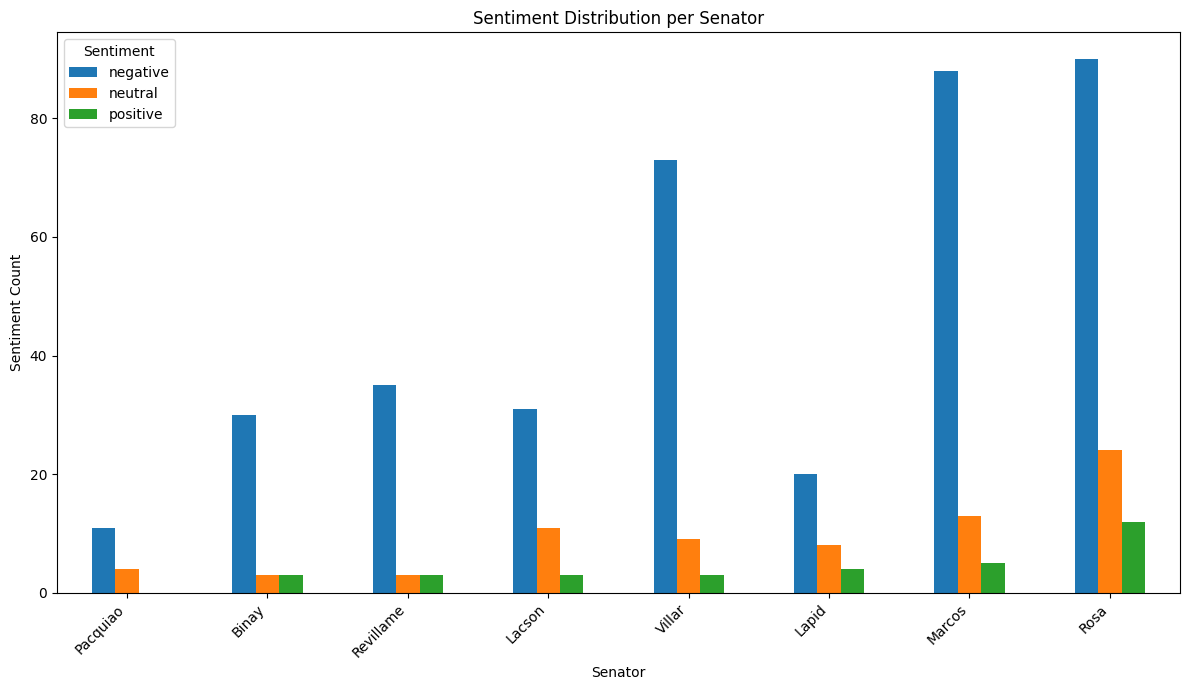

In [9]:
# group by senator and sentiment
sentiment_counts = filtered_df.groupby(['senator', 'sentiment']).size()

# unstack sentiments into columns
sentiment_unstacked = sentiment_counts.unstack(fill_value=0)

# sort dataframe based on positive sentiment
sorted_sentiment_unstacked = sentiment_unstacked.loc[sentiment_unstacked['positive'].sort_values(ascending=True).index]

# plotting
plt.figure(figsize=(12, 7))

sorted_sentiment_unstacked.plot(kind='bar', stacked=False, figsize=(12, 7))

plt.title('Sentiment Distribution per Senator')
plt.xlabel('Senator')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

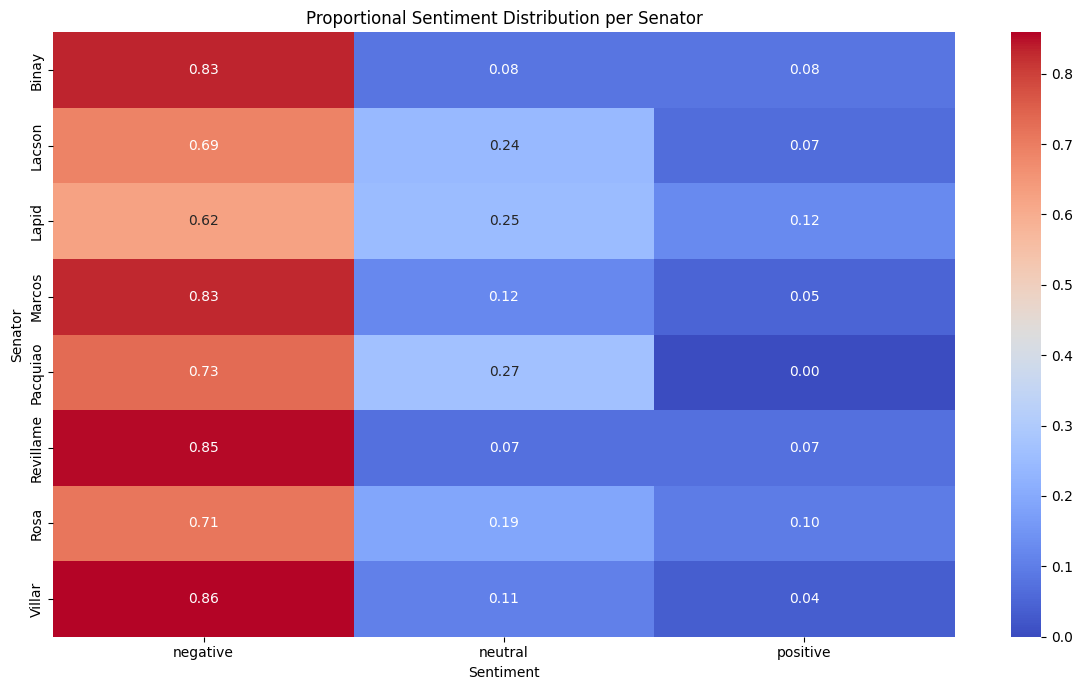

In [10]:
# group by senator and sentiment
sentiment_counts = filtered_df.groupby(['senator', 'sentiment']).size()

# unstack sentiments into columns
sentiment_unstacked = sentiment_counts.unstack(fill_value=0)

# normalize for proportions
sentiment_proportions = sentiment_unstacked.div(sentiment_unstacked.sum(axis=1), axis=0)

# plotting
plt.figure(figsize=(12, 7))

sns.heatmap(sentiment_proportions, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

plt.title('Proportional Sentiment Distribution per Senator')
plt.xlabel('Sentiment')
plt.ylabel('Senator')
plt.tight_layout()
plt.show()

In [ ]:
# filter for negative sentiment
negative_df = filtered_df[filtered_df['sentiment'] == 'negative']

negative_df.groupby('senator').size().sort_values(ascending=False)

senator
Rosa         90
Marcos       88
Villar       73
Revillame    35
Lacson       31
Binay        30
Lapid        20
Pacquiao     11
dtype: int64

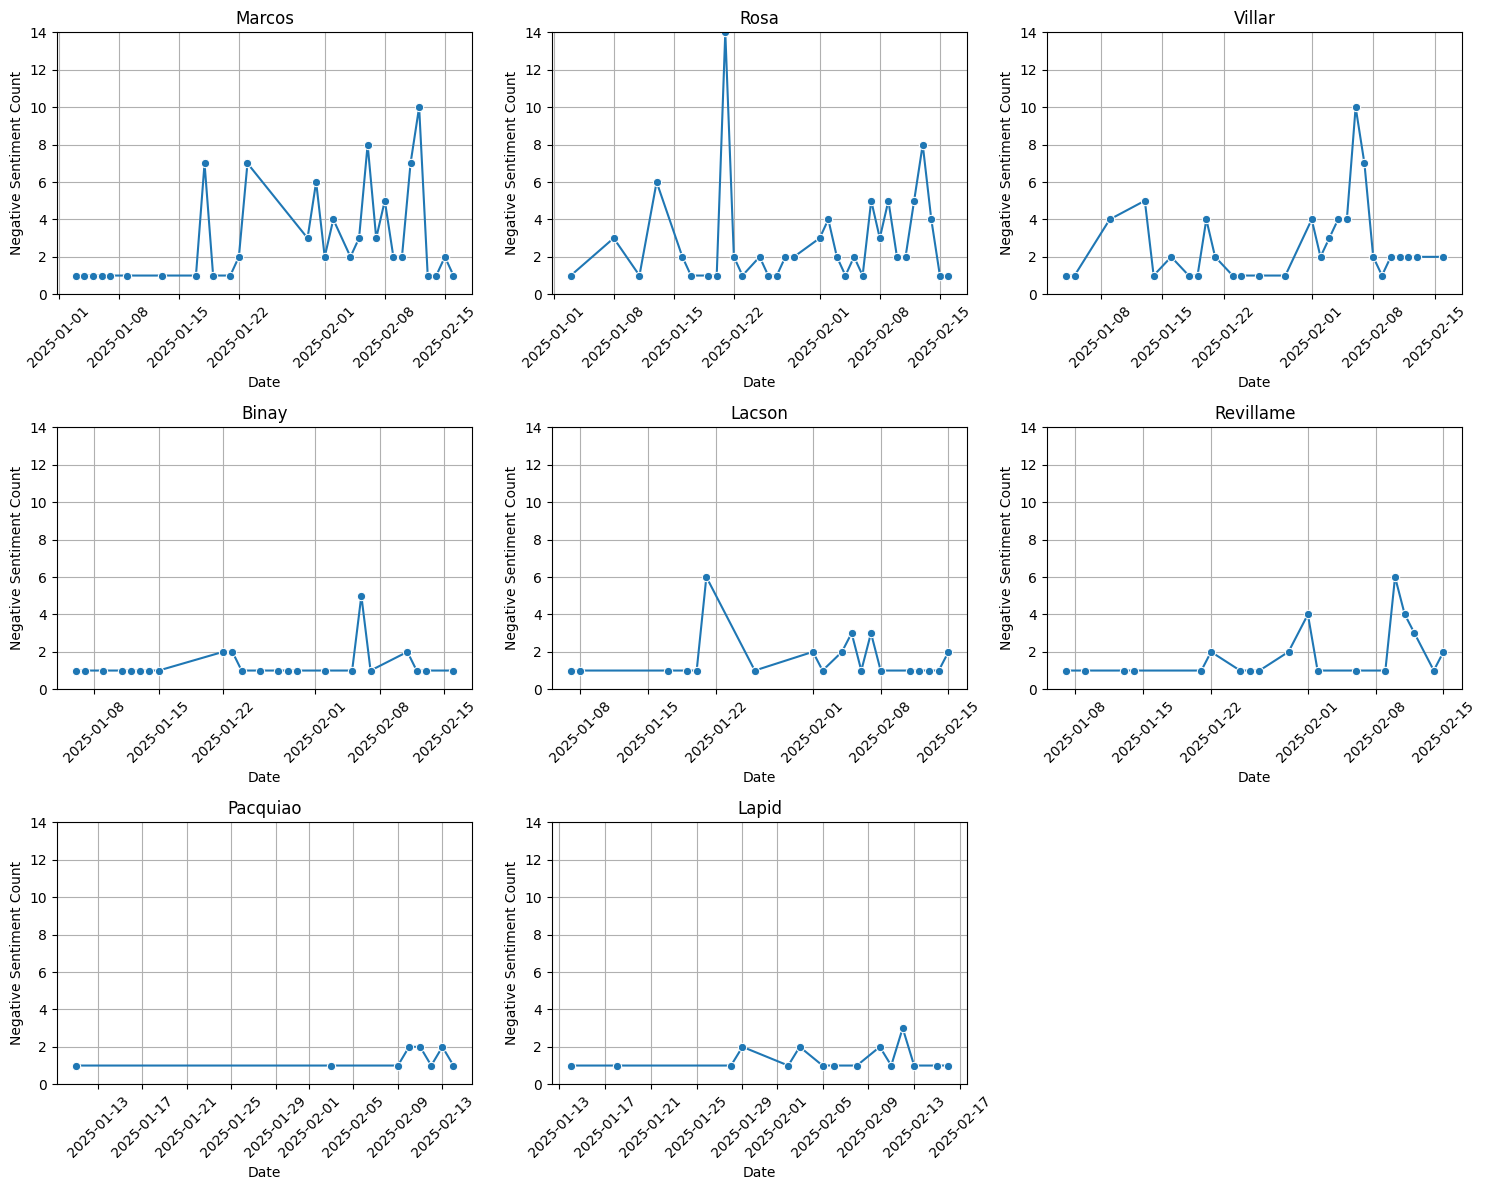

In [ ]:
# group by date and senator, counting negative sentiment occurrences
negative_counts = negative_df.groupby([negative_df['createdAt'].dt.date, 'senator']).size().reset_index(name='count')

# get unique senators
senators = negative_counts['senator'].unique()
num_senators = len(senators)

# max negative sentiment count for y-axis standardization
max_count = negative_counts['count'].max()

# plotting
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten() 

for i, senator in enumerate(senators):
    senator_df = negative_counts[negative_counts['senator'] == senator]
    sns.lineplot(data=senator_df, x='createdAt', y='count', marker="o", ax=axes[i])
    
    axes[i].set_title(f"{senator}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Negative Sentiment Count")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)
    axes[i].set_ylim(0, max_count) 

# hide empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()